# Data Science Introduction using Python

## *Predict Fantasy Point Totals for Tomorrow's NBA Games*
- Step 1:  Get, Prepare and Engineer Features 
- Step 2:  Exploratory Data Analysis
- Step 3:  Split Data into input and Test Data
- Step 4:  Build, Compare and Contrast Different Linear Models
- Step 5:  Summarize Different Model Performances
- Step 6:  Lessons Learned and Next Steps

In [694]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
from sklearn.preprocessing import Imputer, scale, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from scipy.stats.stats import pearsonr

# charts
import matplotlib.pyplot as plt
%matplotlib inline

In [333]:
# define functions to calculate fantasy points for each player
def fantasy_points(data):
    """
    DRAFTKINGS NBA FANTASY SCORING RULES
    - Point = +1 PT
    - Made 3pt. shot = +0.5 PTs
    - Rebound = +1.25 PTs
    - Assist = +1.5 PTs
    - Steal = +2 PTs
    - Block = +2 PTs
    - Turnover = -0.5 PTs
    - Double-Double = +1.5PTs (MAX 1 PER PLAYER: Points, Rebounds, Assists, Blocks, Steals)
    - Triple-Double = +3PTs (MAX 1 PER PLAYER: Points, Rebounds, Assists, Blocks, Steals)
    """
    # calculate basic fantasy points
    basic_pts = (data['PTS'] * 5 + 
                 data['X3P'] * 0.5 +
                 data['TRB'] * 1.25 +
                 data['AST'] * 1.5 +
                 data['STL'] * 2 +
                 data['BLK'] * 2 +
                 data['TOV'] * -0.5)
    
    # get important columns for bonus points
    important_columns = ['index', 'PTS', 'TRB', 'AST', 'BLK', 'STL']
    data2 = data.loc[:, important_columns]  # use .loc for avoiding slice warning bs
    
    # count up number of values above 10 per player and add to data2
    data2['doubles'] = np.sum(data2 >= 10, axis=1)
    
    # calculate bonus fantasy points
    bonus_pts = [1.5 if v == 2 \
                 else 3.0 if v > 2 \
                 else 0 for v in data2['doubles']]
    
    # calculate total points
    total_pts = basic_pts + bonus_pts
    return(total_pts)
    

### Step 1:  Get, Prepare and Engineer Features
Data Cleaning, Analysis and Feature Engineering Packages
- **numpy**: the fundamental package for scientific computing
- **matplotlib**: the most popular Python library for producing plots and other 2D data visualizations
- **pandas**: a library providing high-performance, easy-to-use data structures and data analysis tools
- **SciPy**: a collection of packages addressing a number of different standard problem domains in scientific computing
- **sklearn**: machine learning in Python, preprocessing, scaling, and feature engineering

http://www.kdnuggets.com/2016/10/data-preparation-tips-tricks-tools.html

In [417]:
# drop duplicate columns and columns without any information
columns_to_drop = ['Rk.x', 'Rk.y', 'Age.y',	'G.y', 'MP.y', 'X.', 'X..1']
df.drop(columns_to_drop, axis=1, inplace=True)  # axis 0 for rows, 1 for columns

In [419]:
# drop the duplicated players (players that changed teams, use these data eventually)
df = df[~df.duplicated(subset='Player')]
# filter out the benchwarmers and the 
df = df[df['MP.x'] > 15]

In [421]:
df.shape

(310, 49)

#### Feature Engineering
- Calculate Mean Player Performance over Last 5 Games
- Calculate Mean Points Per Attempt
- Combine Recent Performance with Season and Advanced Stats

https://en.wikipedia.org/wiki/Feature_engineering

In [427]:
# drop the following columns, which won't average properly and aren't helpful
columns_to_drop = ['FG.', 'X3P.', 'FT.']

# intiailize dictionary for containing mean player performance over the last 5 games
d_input = {}

# initialize dictionary for containing the player performance for the next game
d_outcome = {}

# save list of players with limited data for removal
limited_data_players = []

# loop through each player in the NBA and calculate mean input player performance
for player in df.Player:
    f = '../data/game_log_{}_2017-02-16.csv'.format(player.replace(" ", ""))
    
    # read last n rows of data from game log
    gl = pd.read_csv(f).tail(6)
    
    # subset gl to get columns with relevant data
    gl = gl.iloc[:, 10:]
    gl.drop(columns_to_drop, axis=1, inplace=True)
    
    # skip over players with limited data, save list of names
    if gl.shape[0] != 6:
        limited_data_players.append(player)
        print(gl.shape, player)
        continue
    
    # split gl into input and outcome portions
    gl_input = gl[0:5]
    gl_outcome = gl[5:6]
    
    # get mean of each column in gl_input
    gl_mean = gl_input.mean()
    
    # calculate points per attempt and append to gl_mean
    gl_mean['ppa'] = ((gl_mean['FG'] * 2 + gl_mean['X3P'] * 3 + gl_mean['FT'] * 1) / \
                      np.sum(gl_mean[['FGA', 'X3PA', 'FTA']]))
    
    d_input[player] = gl_mean
    d_outcome[player] = gl_outcome.squeeze()  # returns series instead of df

(2, 17) Delon Wright
(3, 17) Jerryd Bayless
(2, 17) Jordan Farmar
(4, 17) Khris Middleton


#### Combine Input and Engineered Feature Data

In [432]:
# convert d_input and d_outcome to dataframes
df_input = pd.DataFrame.from_dict(d_input, orient='index').reset_index()
df_input.columns = ['input_{}'.format(c) for c in df_input.columns]
df_outcome = pd.DataFrame.from_dict(d_outcome, orient='index').reset_index()
print(df_input.shape, df_outcome.shape)

(306, 19) (306, 18)


In [431]:
# remove limited_data_players from df before merging
df = df[~df.Player.isin(limited_data_players)]
df.shape

(306, 49)

In [434]:
# final prep of data by merging df_input with df
data = df.merge(df_input, left_on='Player', right_on='input_index')
data.drop('input_index', 1, inplace=True)

#### Imputation and Standardization
https://www.analyticsvidhya.com/blog/2016/03/tutorial-powerful-packages-imputing-missing-values/
http://stats.stackexchange.com/questions/41704/how-and-why-do-normalization-and-feature-scaling-work

In [437]:
# impute mean feature value, use default imputer from sklearn
imputer = Imputer()

# get only numeric data for imputation
num_data = data._get_numeric_data()

# impute mean feature value and return dataframe
num_data2 = pd.DataFrame(imputer.fit_transform(num_data.values), 
                         columns=num_data.columns)

num_data2.shape

(306, 64)

In [445]:
# standardize numeric data to mean 0, variance 1
num_data3 = pd.DataFrame(scale(num_data2.values), columns=num_data2.columns)
num_data3.shape

(306, 64)

In [446]:
len(fantasy_points(df_outcome))

306

### Step 2: Exploratory Data Analysis
- Descriptive Statistics
- Distribution Analysis
- Correlation Analysis

https://bsdmag.org/python_data/

#### Descriptive Statistics

In [653]:
data.describe()

Age.x         G.x          GS        MP.x          FG         FGA  \
count  306.000000  306.000000  306.000000  306.000000  306.000000  306.000000   
mean    26.846405   46.660131   26.852941   25.283007    4.099346    9.002941   
std      4.038252   11.217763   20.819000    6.374177    2.047101    4.294185   
min     19.000000    3.000000    0.000000   15.100000    1.000000    2.100000   
25%     24.000000   43.250000    6.000000   19.600000    2.600000    5.600000   
50%     26.500000   50.000000   23.500000   25.400000    3.500000    8.000000   
75%     30.000000   55.000000   49.000000   30.800000    5.200000   11.375000   
max     40.000000   58.000000   58.000000   37.700000   10.200000   23.900000   

              FG.         X3P        X3PA        X3P.         X2P        X2PA  \
count  306.000000  306.000000  306.000000  290.000000  306.000000  306.000000   
mean     0.455095    1.033333    2.869608    0.322221    3.067320    6.130392   
std      0.064210    0.794613    2.021740    0.103956    1.818821    3.511950   
min      0.316000    0.000000    0.000000    0.000000    0.300000    0.800000   
25%      0.415250    0.400000    1.425000    0.300250    1.700000    3.400000   
50%      0.447000    0.900000    2.700000    0.349000    2.600000    5.250000   
75%      0.480500    1.500000    4.100000    0.386750    4.200000    8.175000   
max      0.695000    4.000000    9.800000    0.500000    9.700000   19.700000   

             X2P.        eFG.          FT         FTA         FT.         ORB  \
count  306.000000  306.000000  306.000000  306.000000  304.000000  306.000000   
mean     0.496075    0.512395    1.906536    2.464052    0.761020    1.017974   
std      0.065208    0.052864    1.597423    1.908123    0.104475    0.831493   
min      0.261000    0.369000    0.000000    0.000000    0.273000    0.000000   
25%      0.455250    0.478000    0.900000    1.200000    0.708000    0.400000   
50%      0.491000    0.508000    1.450000    1.900000    0.777000    0.700000   
75%      0.529000    0.545000    2.300000    3.000000    0.838500    1.400000   
max      0.750000    0.695000    9.400000   11.000000    1.000000    4.300000   

              DRB         TRB         AST         STL         BLK         TOV  \
count  306.000000  306.000000  306.000000  306.000000  306.000000  306.000000   
mean     3.486275    4.503268    2.403268    0.818627    0.494118    1.424183   
std      1.785297    2.467266    1.929543    0.402060    0.458041    0.794863   
min      0.500000    0.700000    0.300000    0.100000    0.000000    0.200000   
25%      2.200000    2.700000    1.100000    0.500000    0.200000    0.900000   
50%      3.000000    3.800000    1.800000    0.700000    0.400000    1.300000   
75%      4.375000    5.600000    3.000000    1.000000    0.600000    1.800000   
max     10.500000   14.100000   11.300000    2.200000    2.500000    5.800000   

               PF        PS.G         PER         TS.       X3PAr         FTr  \
count  306.000000  306.000000  306.000000  306.000000  306.000000  306.000000   
mean     2.051307   11.139216   14.435948    0.547219    0.322846    0.266395   
std      0.589594    5.877266    4.907700    0.050775    0.197671    0.135126   
min      0.600000    2.700000    5.900000    0.397000    0.000000    0.000000   
25%      1.600000    6.825000   11.000000    0.512250    0.178500    0.174250   
50%      2.000000    9.400000   13.600000    0.545000    0.339000    0.234500   
75%      2.400000   13.900000   17.075000    0.580000    0.463750    0.338500   
max      3.900000   31.100000   29.500000    0.710000    0.750000    0.850000   

             ORB.        DRB.        TRB.        AST.        STL.        BLK.  \
count  306.000000  306.000000  306.000000  306.000000  306.000000  306.000000   
mean     4.540850   15.244118    9.887255   14.229412    1.586601    1.626144   
std      3.611675    6.256159    4.634787    9.622221    0.609259    1.395650   
min      0.000000    3.200000    2.600

#### Distribution Analysis
- Histograms of Individual Features
- Boxplot comparison of all Features

##### Histograms

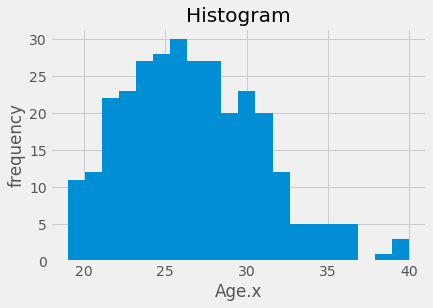

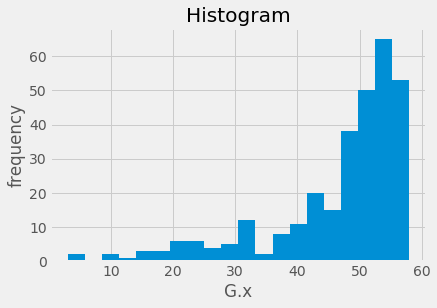

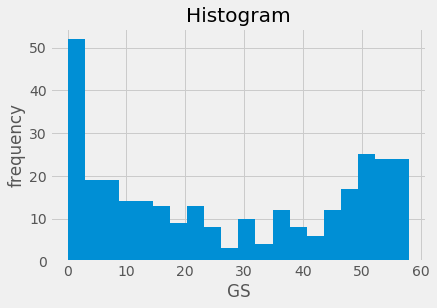

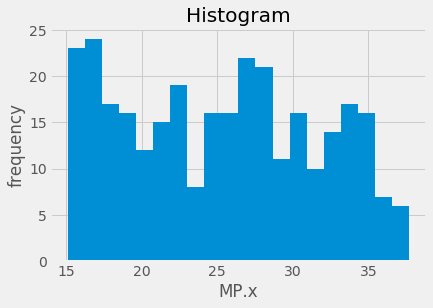

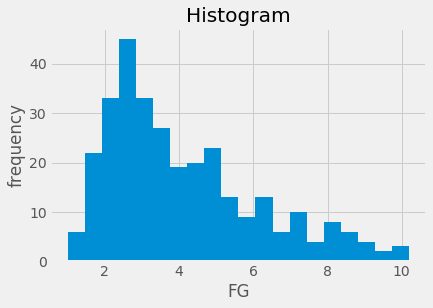

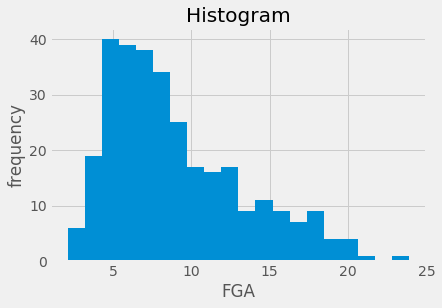

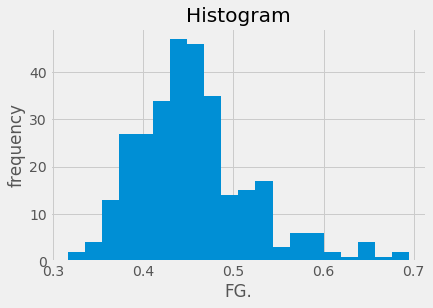

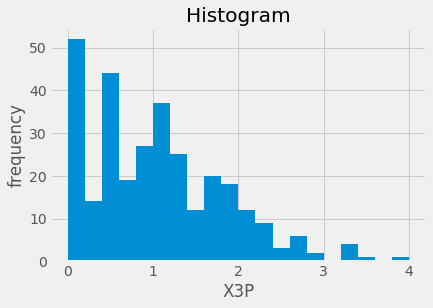

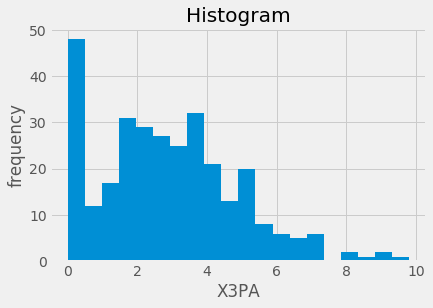

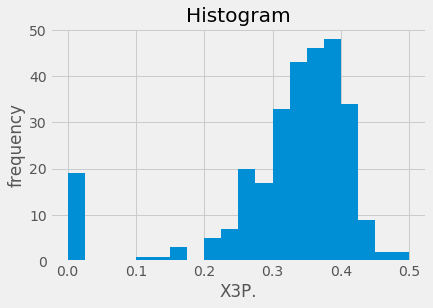

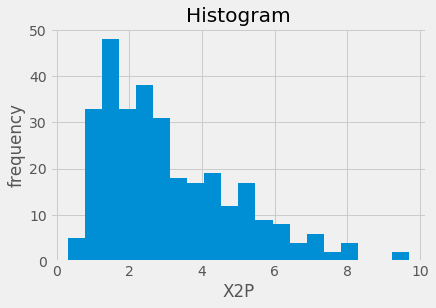

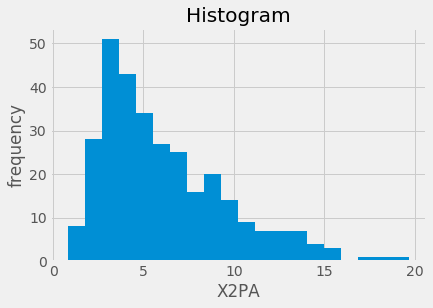

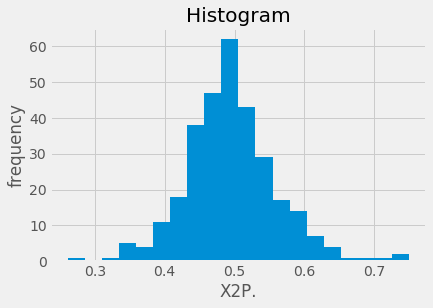

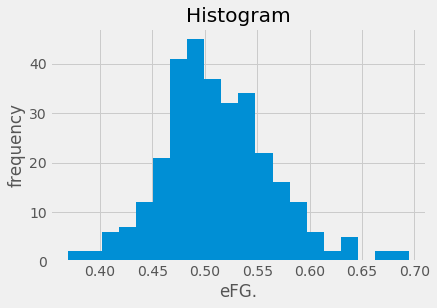

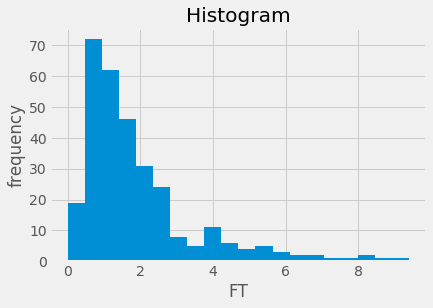

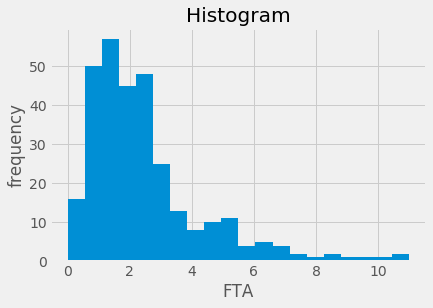

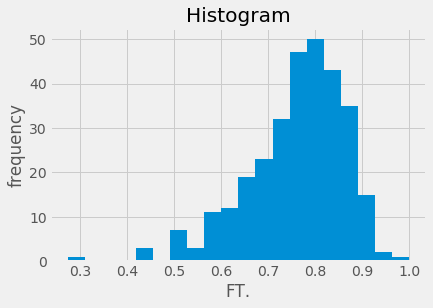

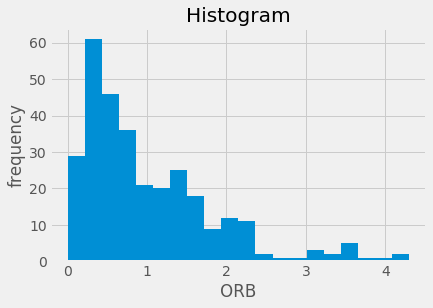

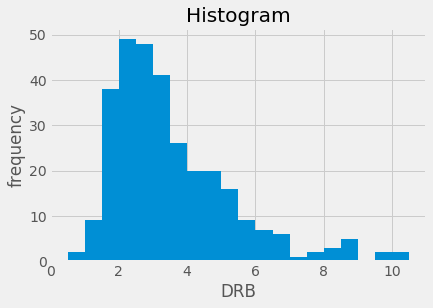

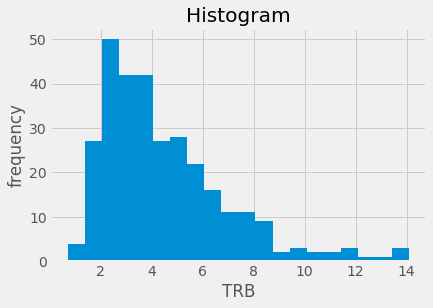

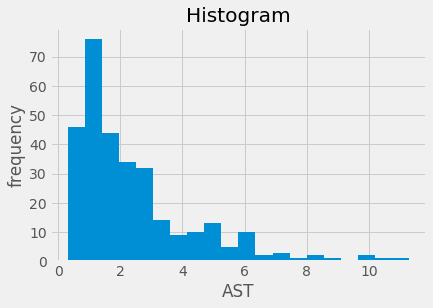

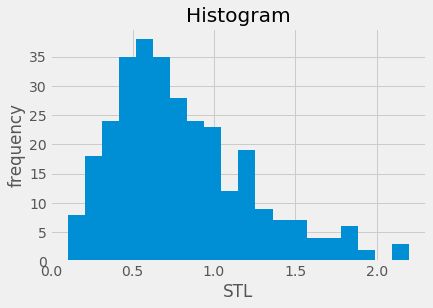

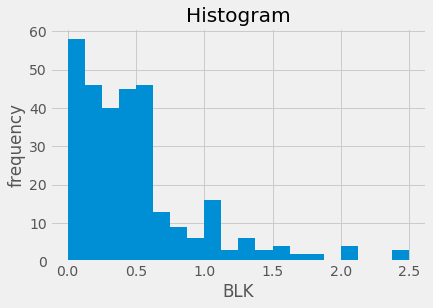

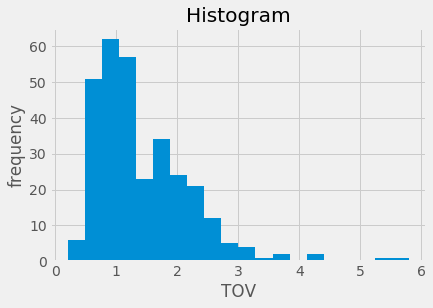

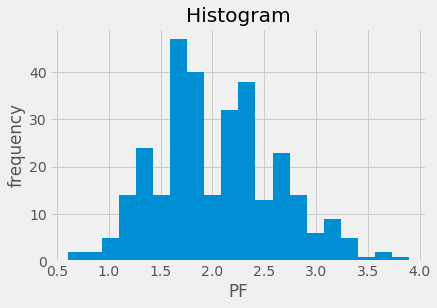

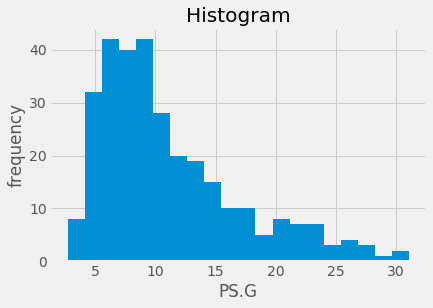

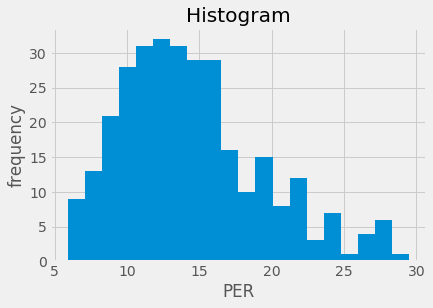

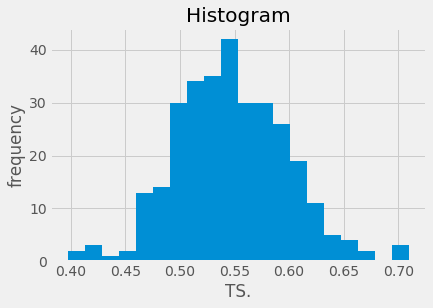

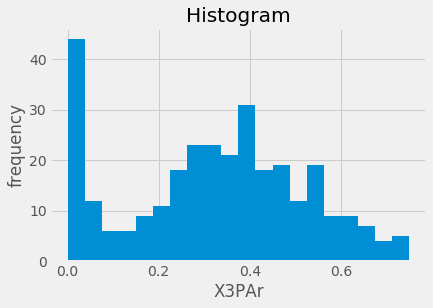

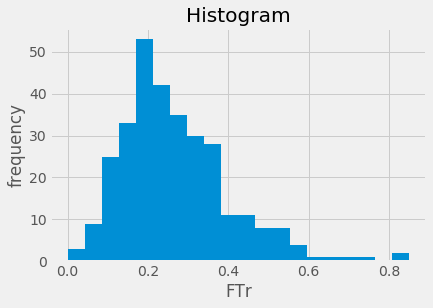

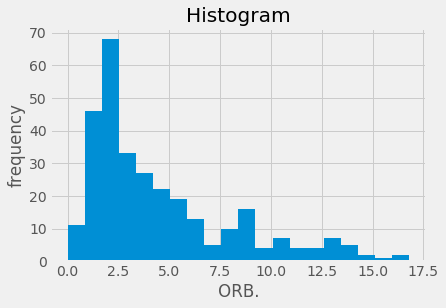

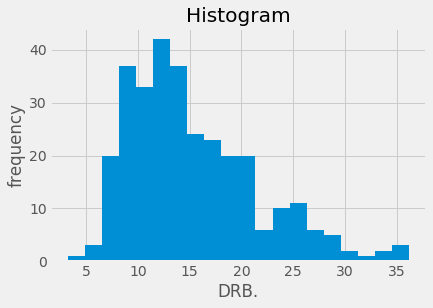

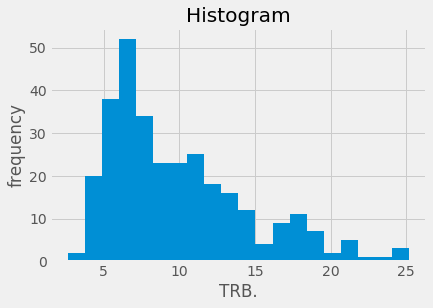

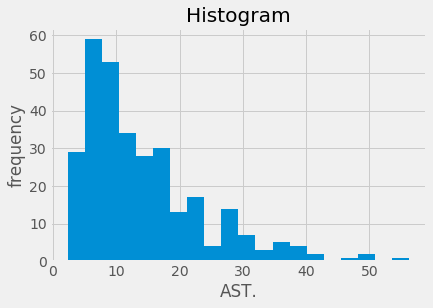

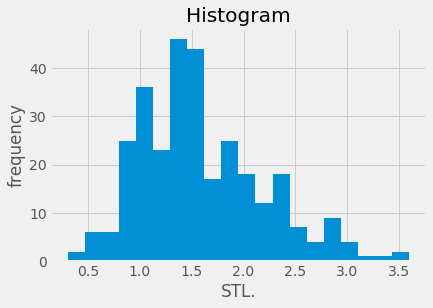

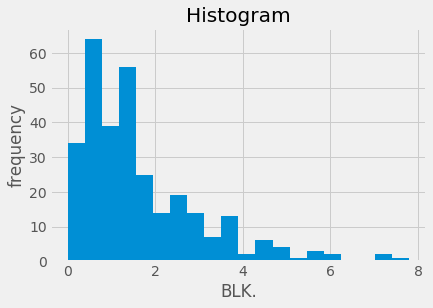

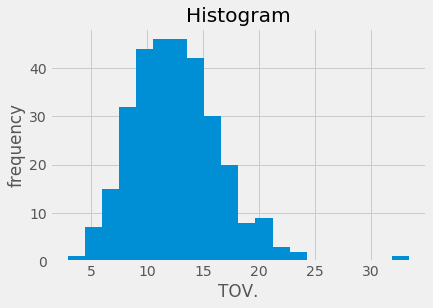

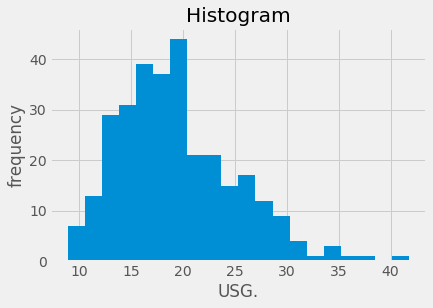

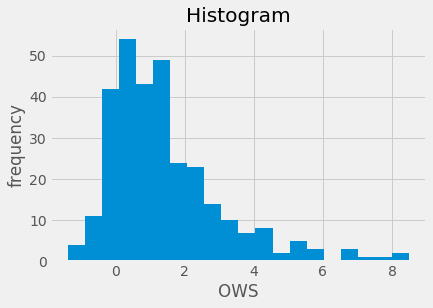

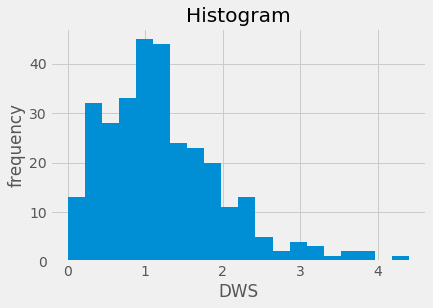

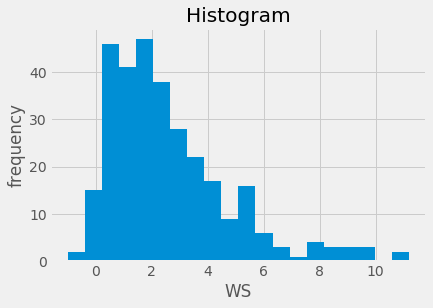

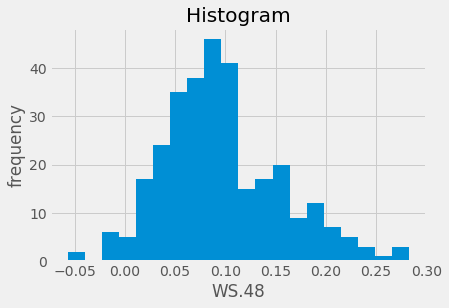

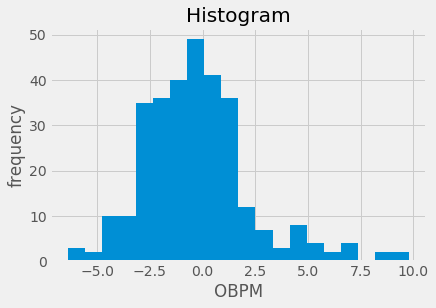

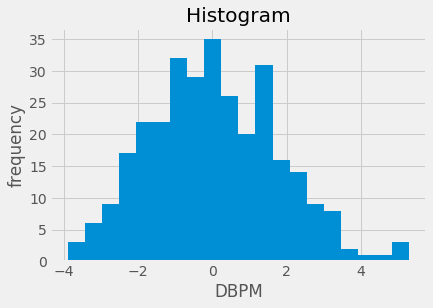

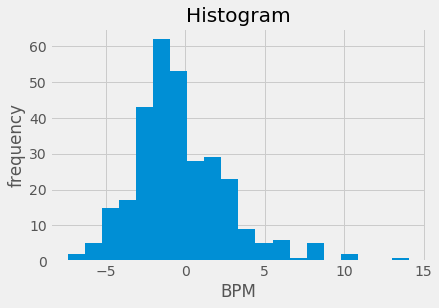

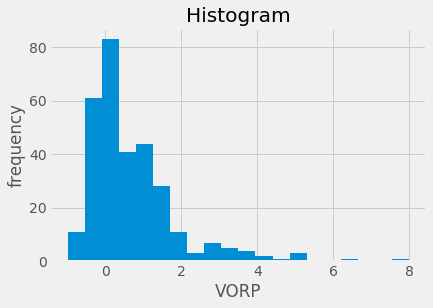

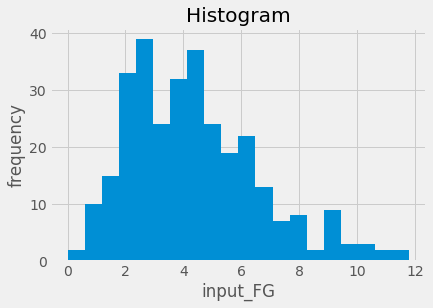

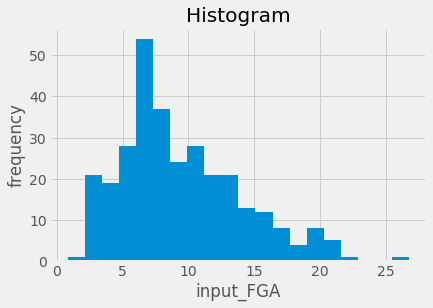

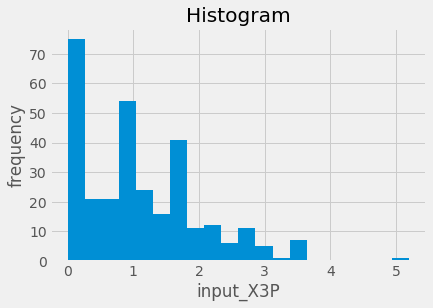

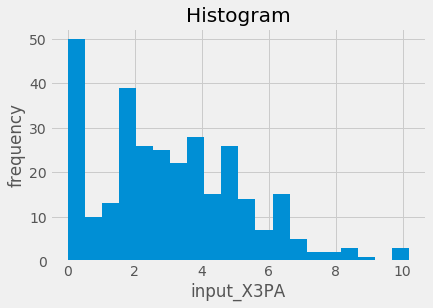

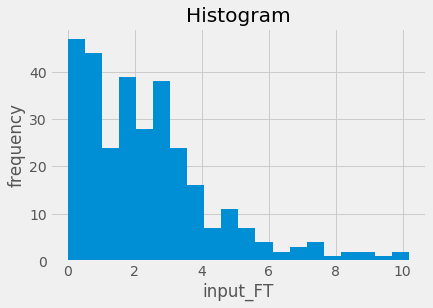

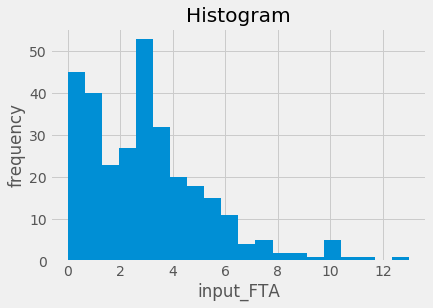

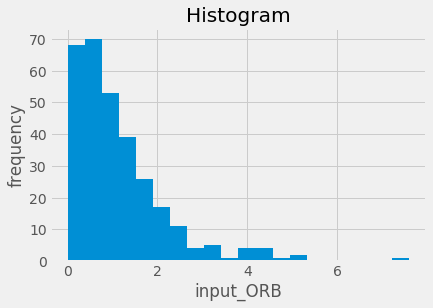

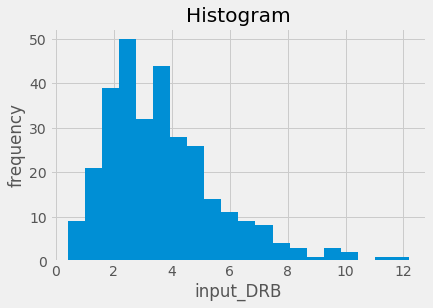

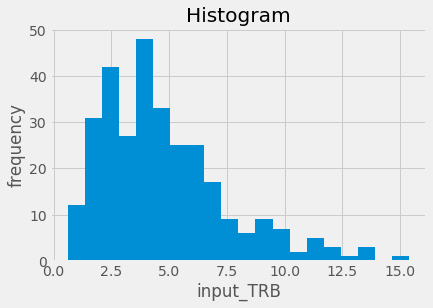

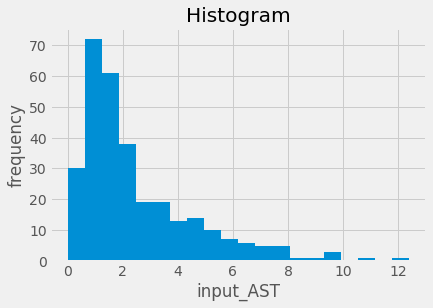

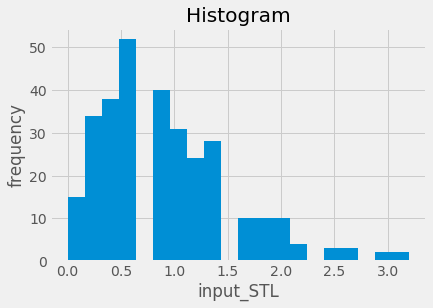

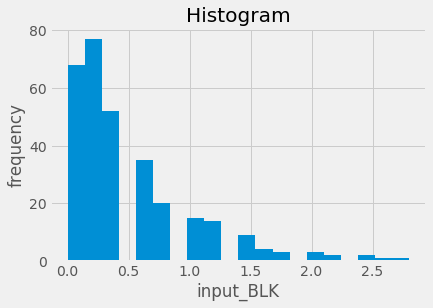

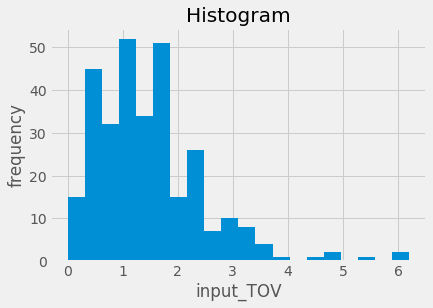

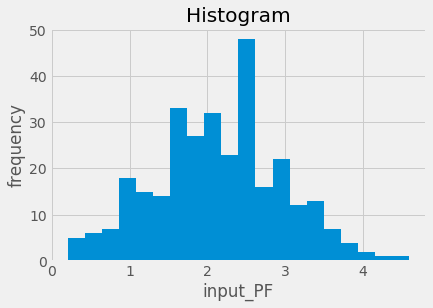

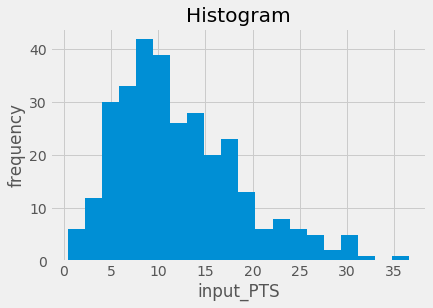

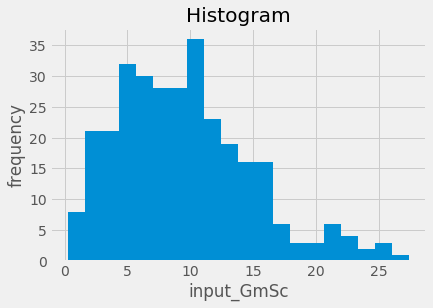

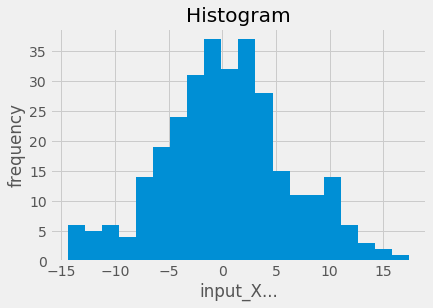

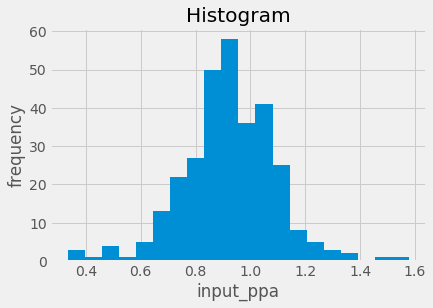

In [706]:
plt.style.use('fivethirtyeight')
# distribution analysis of numeric data
for c in num_data2.columns:
    data[c].hist(bins=20)
    plt.title('Histogram')
    plt.xlabel(c)
    plt.ylabel('frequency')
    plt.show()

##### Boxplots

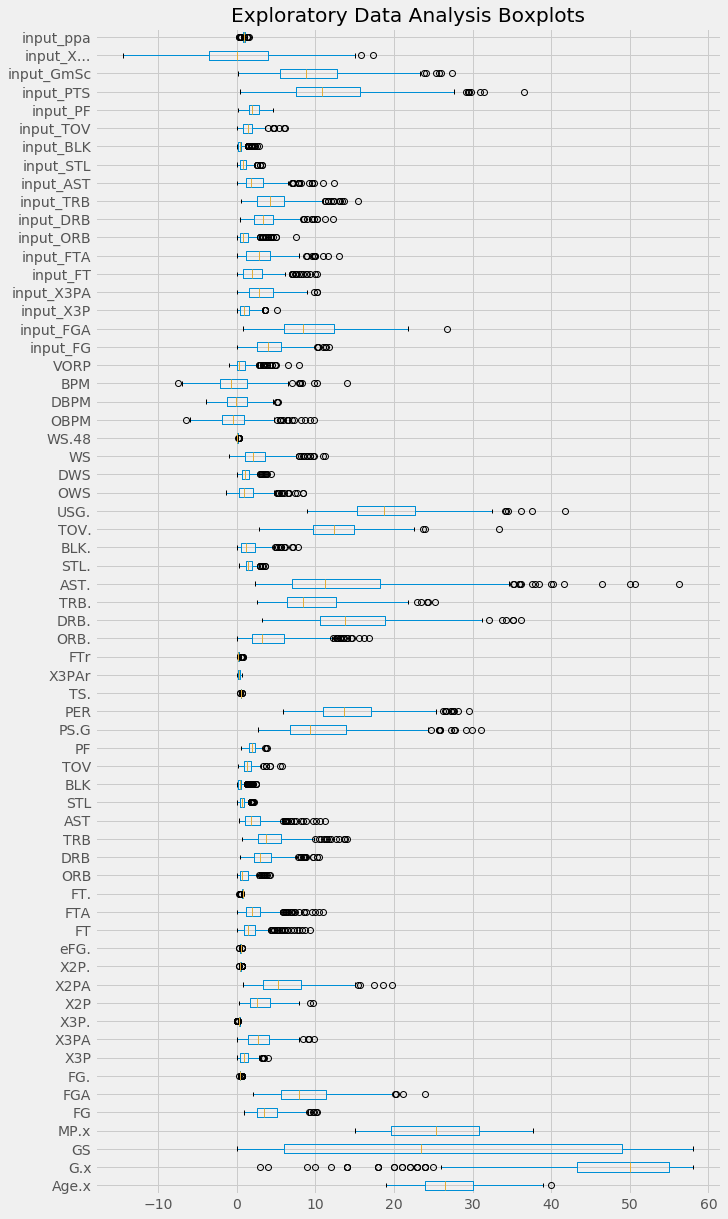

In [443]:
plt.figure(figsize=(10,20))
num_data2.boxplot(vert=False)
plt.title('Exploratory Data Analysis Boxplots')

#### Correlation Analysis - Scatterplots
Note: Standardized Data Displayed

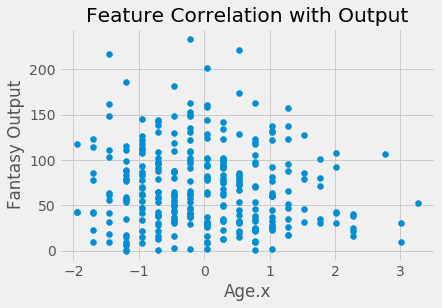

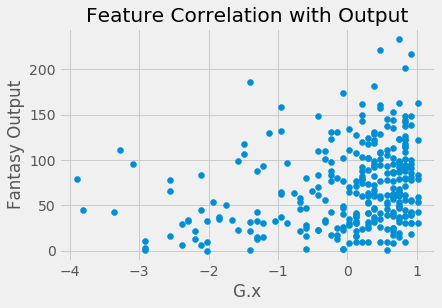

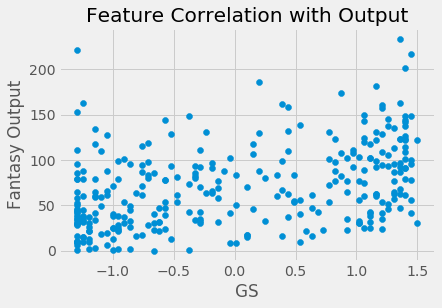

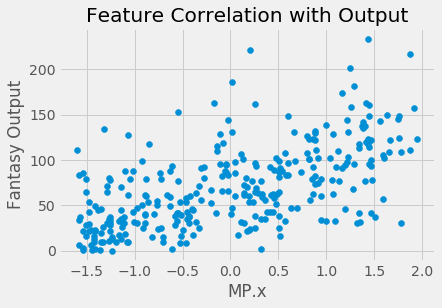

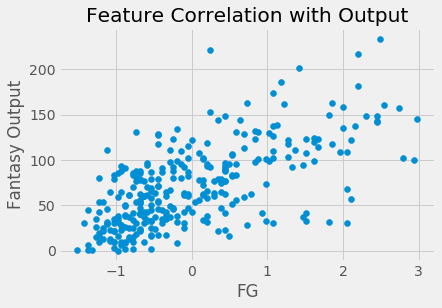

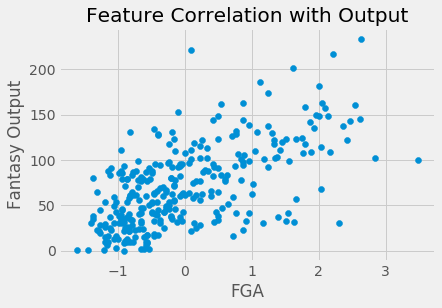

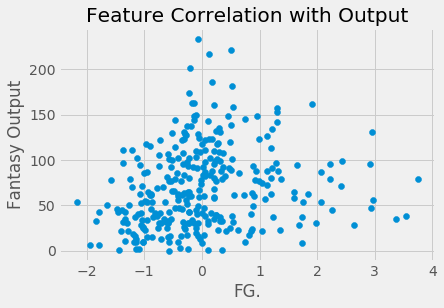

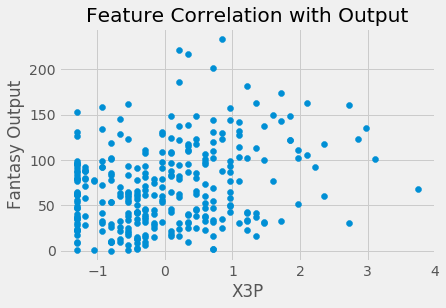

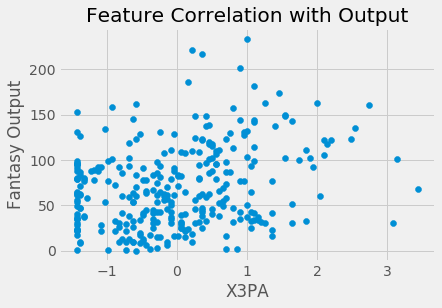

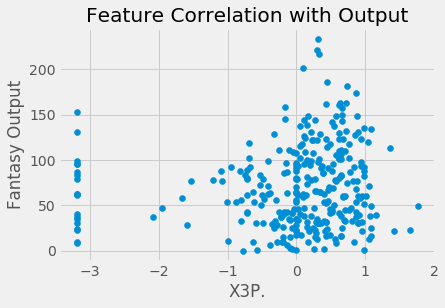

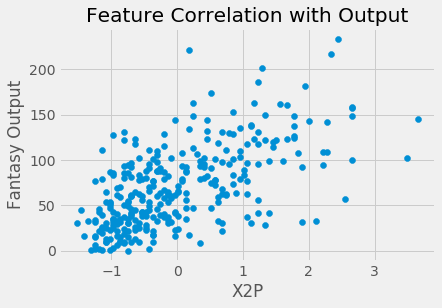

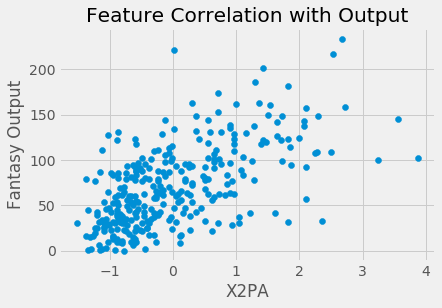

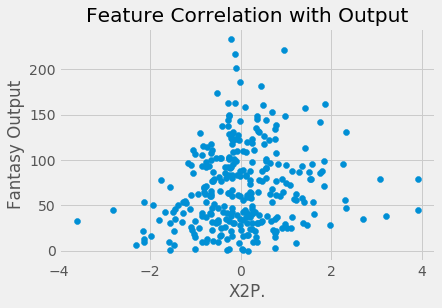

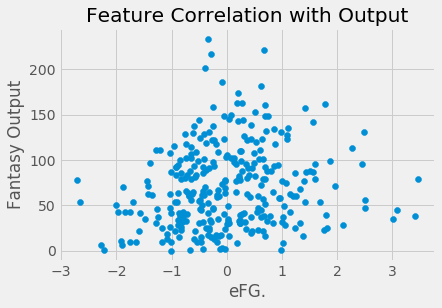

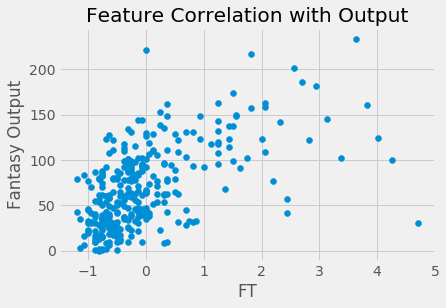

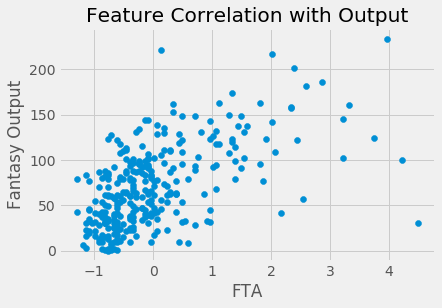

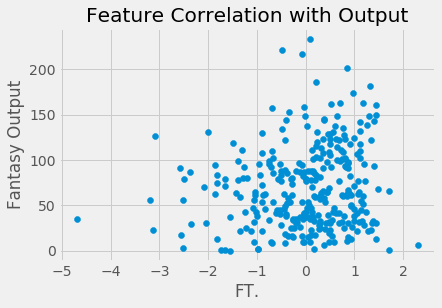

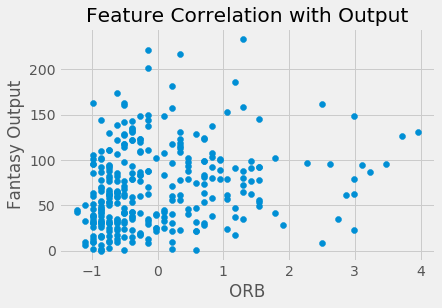

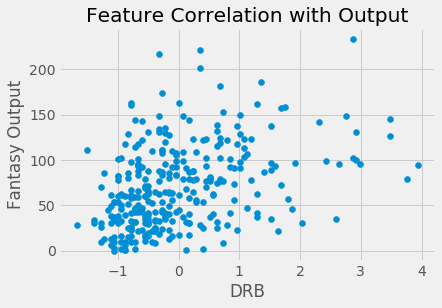

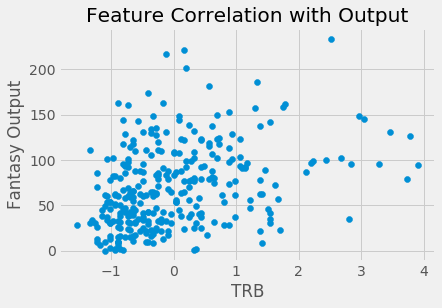

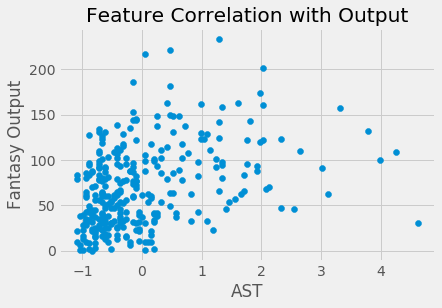

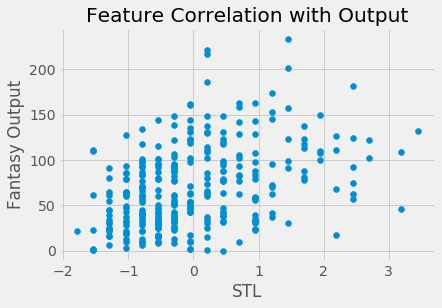

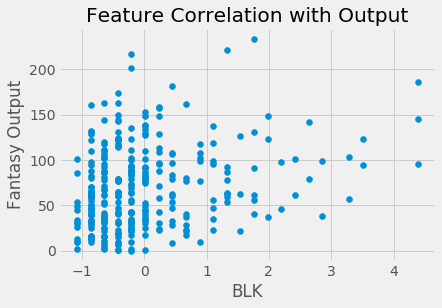

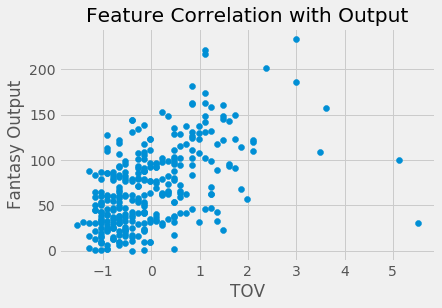

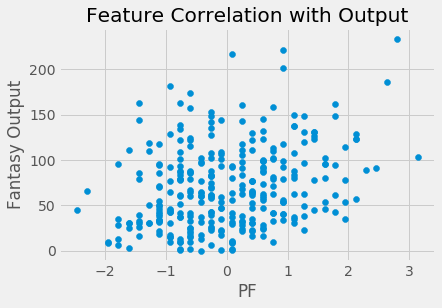

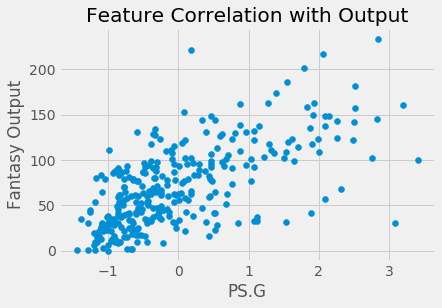

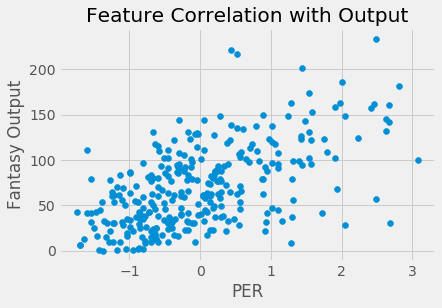

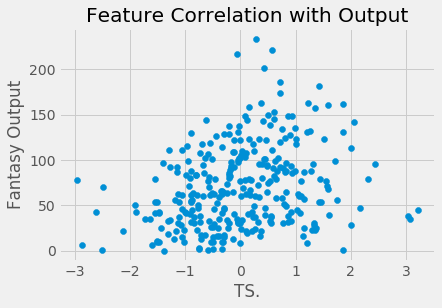

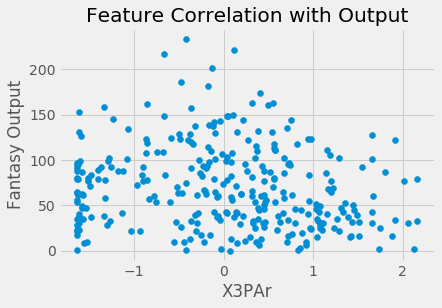

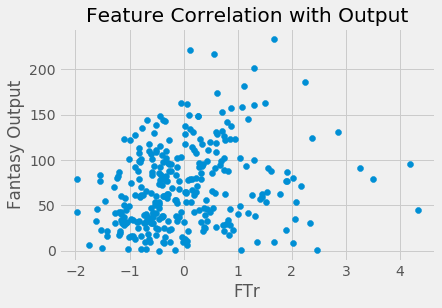

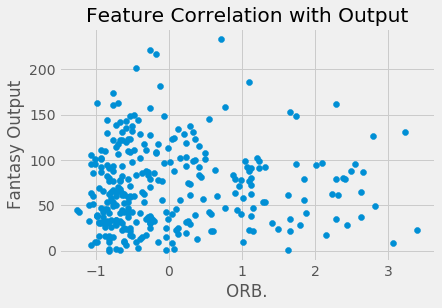

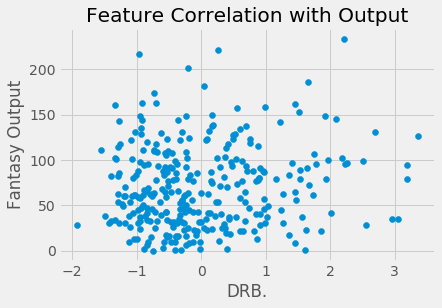

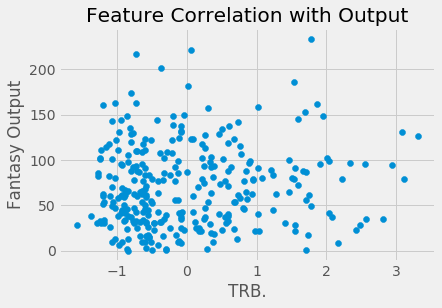

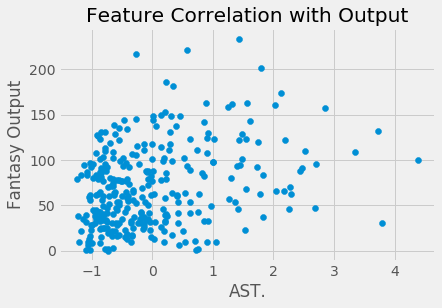

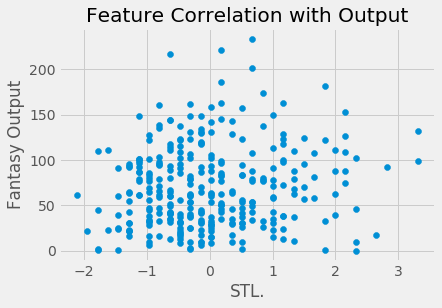

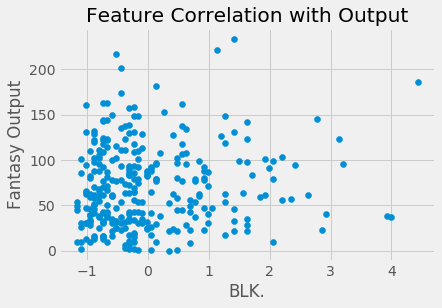

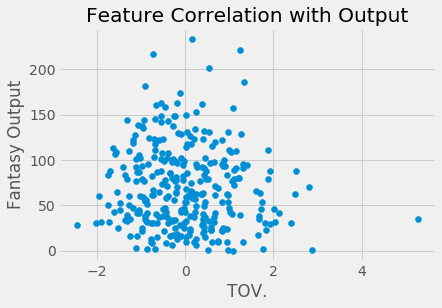

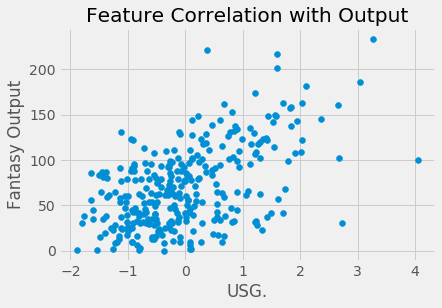

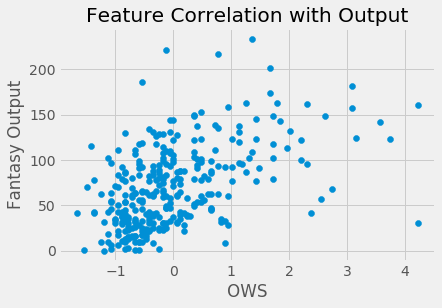

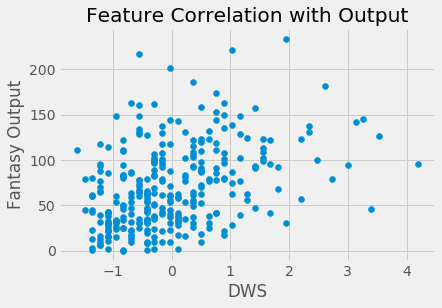

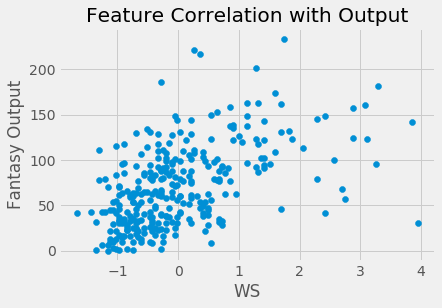

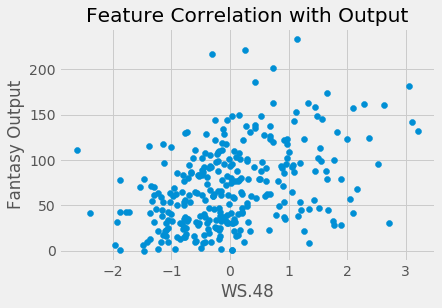

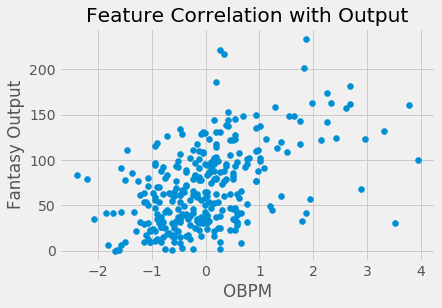

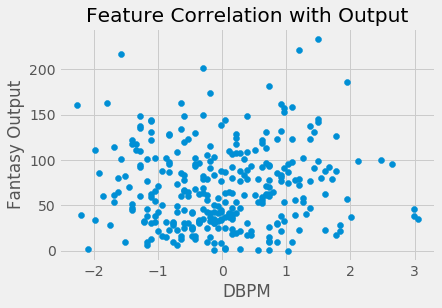

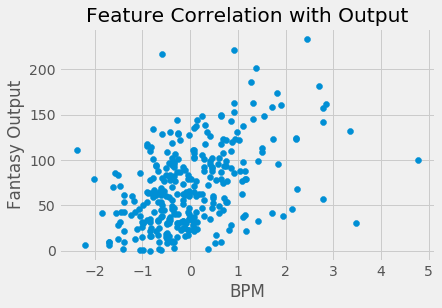

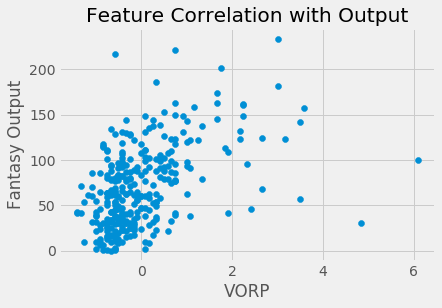

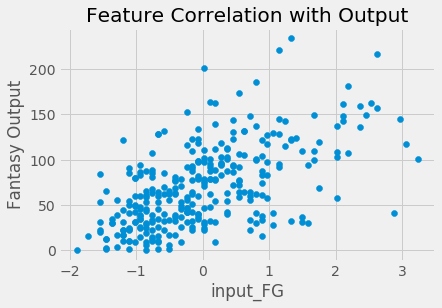

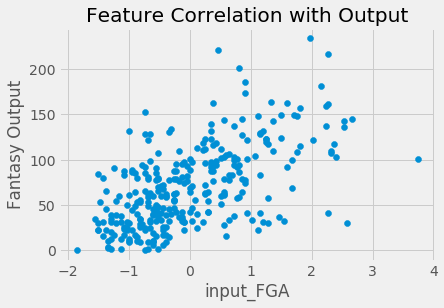

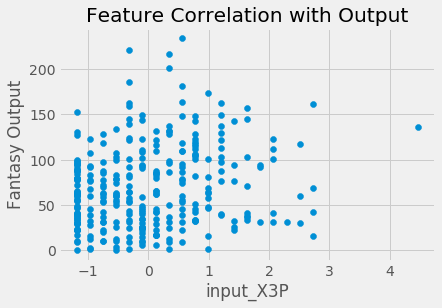

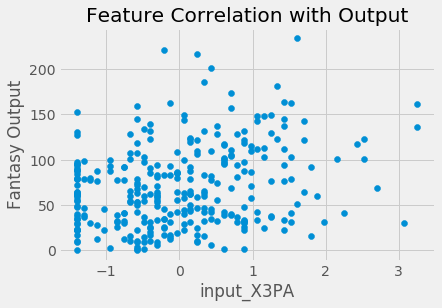

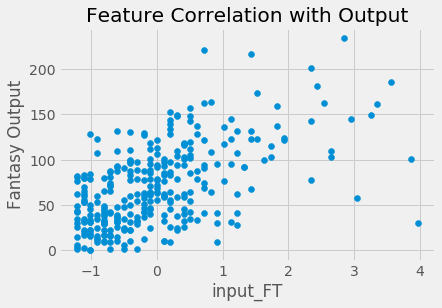

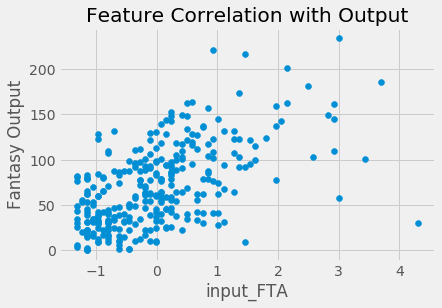

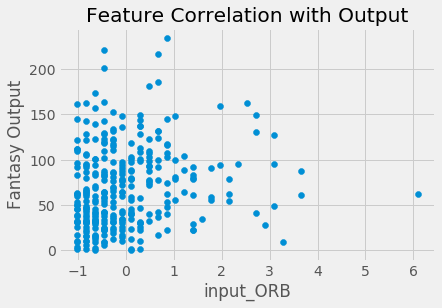

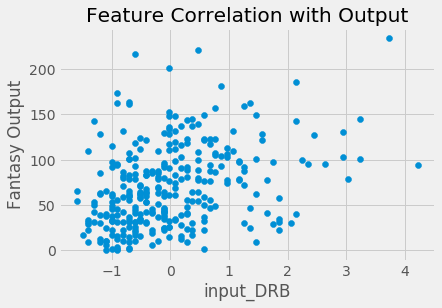

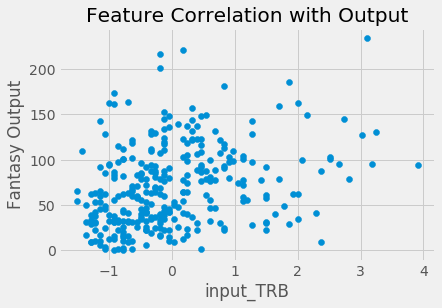

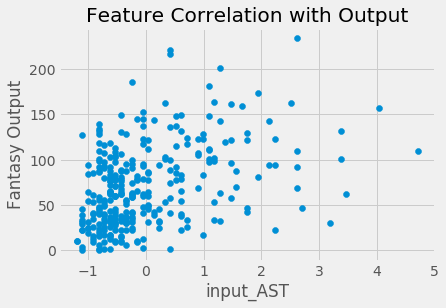

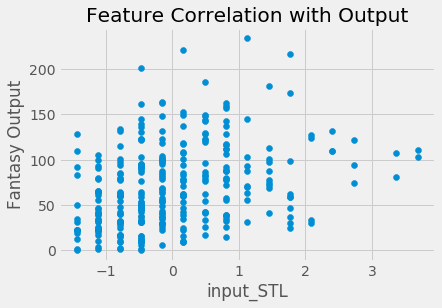

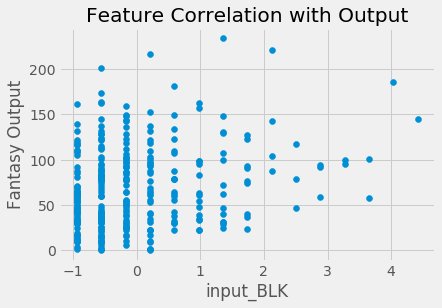

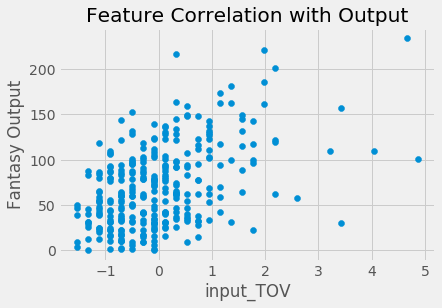

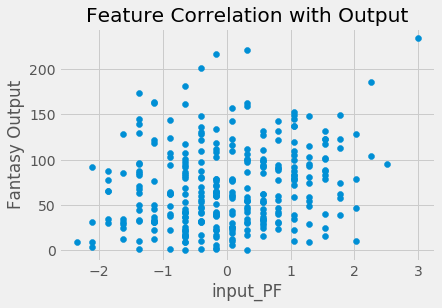

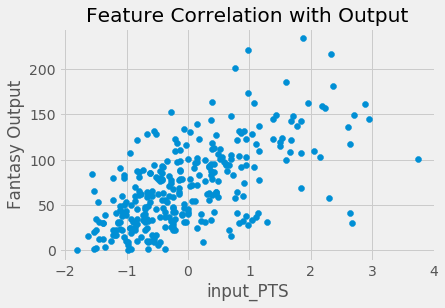

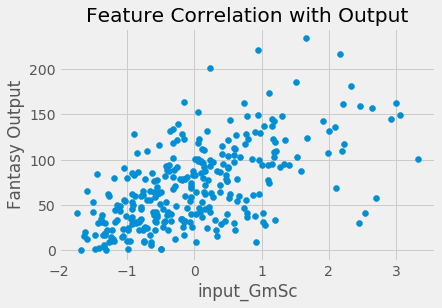

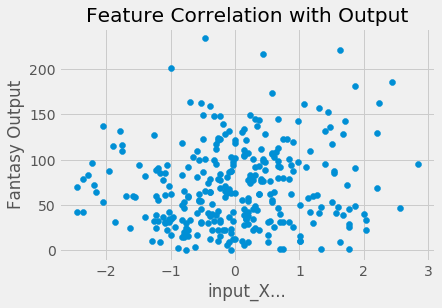

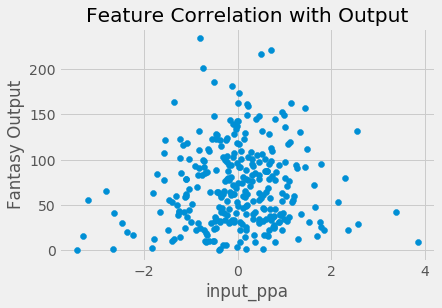

ValueError: First argument must be a sequence

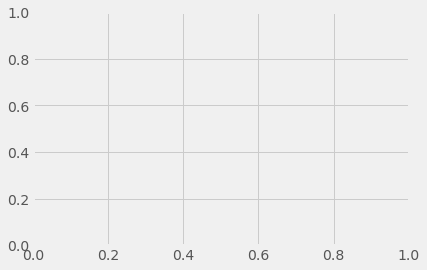

In [542]:
for c in num_data3.columns:
    plt.scatter(x=num_data3[c], y=fantasy_points(df_outcome))
    plt.xlabel(c)
    plt.ylabel('Fantasy Output')
    plt.title('Feature Correlation with Output')
    plt.show()

#### Correlation Analysis - Pearson Correlation of Features with Fantasy Points

(-1, 1)

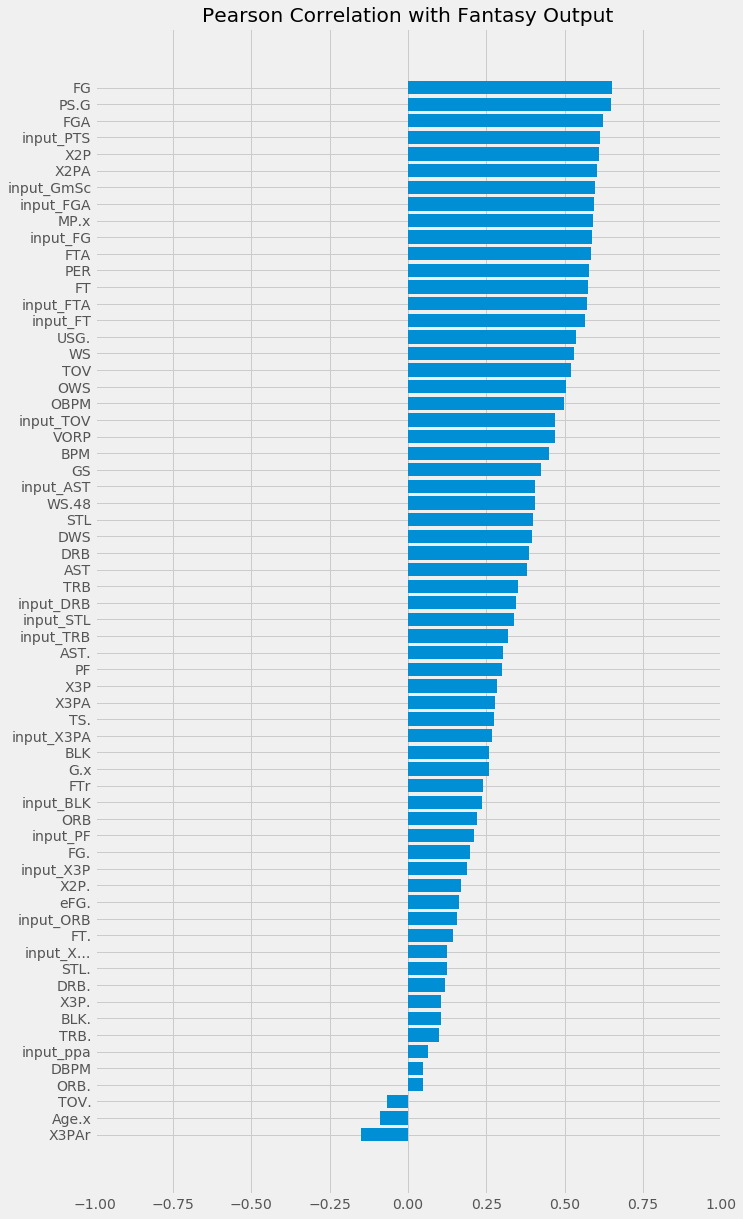

In [481]:
outcome = fantasy_points(df_outcome)
plt.figure(figsize=(10,20))
pearson = np.array([pearsonr(outcome, num_data3[c])[0] \
                    for c in num_data3.columns])
sort_indices = np.argsort(pearson)
pos = np.arange(num_data3.shape[1])
fig = plt.barh(pos, pearson[sort_indices])
y_labels = plt.yticks(pos, np.array(num_data3.columns)[sort_indices])
title = plt.title('Pearson Correlation with Fantasy Output')
plt.xlim(-1,1)

### Final Dataset for Model Building

In [489]:
# add player and outcome information to num_data3
num_data3['Player'] = df.Player.values
num_data3['next_game_fpts'] = fantasy_points(df_outcome)

# final dataset
df_clean = num_data3

In [492]:
df_clean.head()

Age.x       G.x        GS      MP.x        FG       FGA       FG.  \
0 -1.450128  0.833960  1.017421  0.364092  0.098179  0.232568 -0.422664   
1  0.782210 -0.237524  0.824975  1.212648  0.832123  0.862356  0.060919   
2 -0.209940 -0.862556 -0.185372  0.599802 -0.586835 -0.257266 -1.374230   
3 -0.457978 -2.291202 -1.291941 -1.584443 -0.782554 -0.793751 -0.173072   
4 -0.954053  0.655380 -0.762712 -0.893027 -0.586835 -0.770426  0.731696   

        X3P      X3PA      X3P.       X2P      X2PA      X2P.      eFG.  \
0 -0.042018  0.262774 -0.299136  0.128138  0.133936  0.044927 -0.651704   
1  0.588250  0.708664  0.314564  0.678846  0.647311  0.244615  0.125139   
2  0.084036  0.411404 -0.150660 -0.697923 -0.550564 -1.168561 -1.390652   
3 -0.546232 -0.529920  0.017612 -0.642852 -0.664648  0.060288 -0.310651   
4 -1.302553 -1.372157 -0.714868 -0.147215 -0.151272  0.137091 -0.178019   

         FT       FTA       FT.       ORB       DRB       TRB       AST  \
0 -0.192208 -0.033623 -1.067895  0.339736 -0.104509  0.039270 -0.261250   
1 -0.192208 -0.243597  0.442283  0.460199  1.017588  0.891809  1.347980   
2 -0.317615 -0.348583 -0.144474  0.219273  1.522531  1.175989 -0.157428   
3 -0.317615 -0.191103 -0.760088 -0.985352 -1.058291 -1.056851 -0.936088   
4 -0.066802  0.018870 -0.288759  1.062511  0.568749  0.770018 -0.936088   

        STL       BLK       TOV        PF      PS.G       PER       TS.  \
0 -0.295533 -0.205815 -0.408516  0.082722  0.010359 -0.395118 -0.872299   
1 -0.046406  2.199651  0.473582  0.252608  0.623892  0.686587 -0.043773   
2  0.451848  0.231542  0.095540 -0.426936 -0.483876 -0.803308 -1.404924   
3 -0.544660 -0.861852 -0.660544 -1.106480 -0.705429 -0.415527 -0.241041   
4 -1.042913  1.762294 -0.156488  1.781582 -0.620216  0.033482  0.173222   

      X3PAr       FTr      ORB.      DRB.      TRB.      AST.      STL.  \
0  0.097055 -0.166009  0.155071 -0.295251 -0.170136 -0.315351 -0.471180   
1  0.081853 -0.803497  0.016404  0.457239  0.326924  0.996263 -0.799985   
2  0.725386 -0.284612 -0.066796  1.401855  0.888818 -0.429857  0.186430   
3 -0.034692  0.812460 -0.732396 -0.535408 -0.623974 -0.762965  0.679638   
4 -1.570050  1.257218  1.624938  1.738074  1.753270 -1.033615 -1.128790   

       BLK.      TOV.      USG.       OWS       DWS        WS     WS.48  \
0 -0.234069 -0.885446  0.042659 -0.537272 -0.028851 -0.470309 -0.765046   
1  1.631914 -0.302983  0.240987  0.473538  0.498214  0.587210  0.551490   
2  0.124774  0.558049 -0.696564 -1.072407 -0.292383 -0.884121 -1.124101   
3 -0.592912 -0.227010  0.601583 -0.834569 -0.951215 -0.976079 -0.354697   
4  2.636674  0.963240 -0.353997 -0.358894 -0.160617 -0.332372 -0.149523   

       OBPM      DBPM       BPM      VORP  input_FG  input_FGA  input_X3P  \
0 -0.284441 -0.243052 -0.382332 -0.422321 -0.501262   0.079401  -0.534037   
1  0.576943  1.084022  1.114176  0.995959 -0.067478   0.424032   0.335193   
2 -0.950056  0.680130 -0.448844 -0.505750 -0.067478   0.036322   1.204424   
3 -0.832595 -0.358449 -0.914424 -0.672606 -0.501262  -0.480626  -0.316729   
4 -1.224133  0.680130 -0.615123 -0.589178 -0.848290  -0.997574  -1.185960   

   input_X3PA  input_FT  input_FTA  input_ORB  input_DRB  input_TRB  \
0   -0.031026  0.204898   0.239920   0.097914  -0.706061  -0.487329   
1    0.607995 -0.404814  -0.451049   0.285173   1.163265   0.977531   
2    0.881861  0.103279  -0.019194  -0.089346   1.753578   1.270503   
3   -0.304893 -0.608052  -0.710163  -0.838386  -0.706061  -0.853544   
4   -1.400358 -0.099958  -0.019194   1.408733  -0.017362   0.538073   

   input_AST  input_STL  input_BLK  input_TOV  input_PF  input_PTS  \
0  -0.624232  -0.154768  -0.172325  -0.709664 -0.406879  -0.367536   
1   1.183181  -0.154768   0.974008   0.322452  0.563920  -0.122445   
2  -0.529105  -0.154768  -0.172325  -0.296818 -0.649578   0.153282   
3  -0.624232  -0.474760  -0.554435  -0.296818 -1.134978  -0.581990   
4  -0.909613  -1.114746   0.209786   0.322452  0.078520  -0.

### Step 3:  Split data into train and test sets

In [528]:
from sklearn.model_selection import train_test_split
X = df_clean.loc[:,df_clean.columns[0:-2]].values
y = df_clean.next_game_fpts

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=1234)

print(len(y_train), len(y_test))

205 101


### Step 4: Build, Compare and Contrast Different Linear Models

#### Simple Linear Regression Model with all Features
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Performance Evaluation
--------------------------------

Sum of Coefficients: 
 122.204494048
Train Mean squared error: 726.89
Test Mean squared error: 1958.35
Training R^2 score: 0.67
Testing R^2 score: -0.19


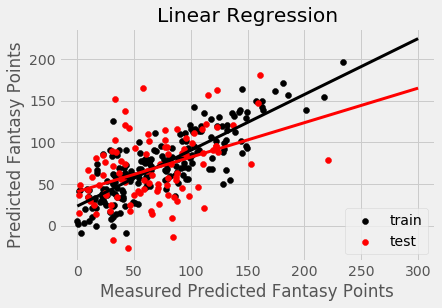

In [657]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Predict fantasy points on train and test data
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

print('Performance Evaluation')
print('--------------------------------')
print('')

# The coefficients
print('Sum of Coefficients: \n', np.sum(regr.coef_))

# The mean squared error
print("Train Mean squared error: %.2f"
      % mean_squared_error(y_train_pred, y_train))
print("Test Mean squared error: %.2f"
      % mean_squared_error(y_test_pred, y_test))

# Train R2
print('Training R^2 score: %.2f' % regr.score(X_train, y_train))
# Test R2
print('Testing R^2 score: %.2f' % regr.score(X_test, y_test))

# Plot outputs
plt.scatter(y_train,  y_train_pred, color='black', label='train')
plt.scatter(y_test,  y_test_pred, color='red', label='test')
plt.title('Linear Regression')
plt.xlabel('Measured Predicted Fantasy Points')
plt.ylabel('Predicted Fantasy Points')

# plot best fit lines for train and test
fit = np.polyfit(y_train, y_train_pred, deg=1)
poly = np.poly1d(fit)
xpoints = np.linspace(0.0, 300, 100)
plt.plot(xpoints, poly(xpoints), color='black', linewidth=3)

fit = np.polyfit(y_test, y_test_pred, deg=1)
poly = np.poly1d(fit)
xpoints = np.linspace(0.0, 300, 100)
plt.plot(xpoints, poly(xpoints), color='red', linewidth=3)
plt.legend(loc='lower right')
plt.show()

#### Simple Linear Regression Model with L2 Regularization (Ridge Regression)
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Performance Evaluation, alpha = 0.01
--------------------------------

Sum of Coefficients: 
 103.697612841
Train Mean squared error: 730.01
Test Mean squared error: 1870.70
Training R^2 score: 0.67
Testing R^2 score: -0.14


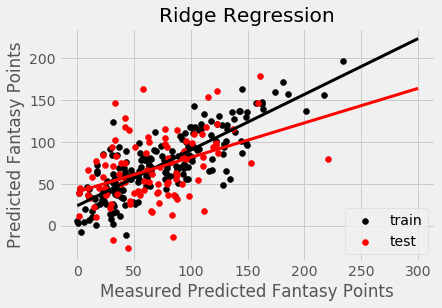

Performance Evaluation, alpha = 0.1
--------------------------------

Sum of Coefficients: 
 57.6351057827
Train Mean squared error: 748.23
Test Mean squared error: 1749.61
Training R^2 score: 0.66
Testing R^2 score: -0.06


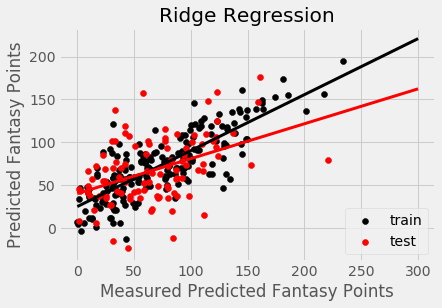

Performance Evaluation, alpha = 1.0
--------------------------------

Sum of Coefficients: 
 44.9145598011
Train Mean squared error: 782.27
Test Mean squared error: 1589.08
Training R^2 score: 0.64
Testing R^2 score: 0.03


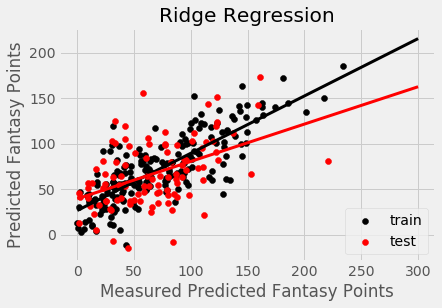

Performance Evaluation, alpha = 10
--------------------------------

Sum of Coefficients: 
 47.6693453537
Train Mean squared error: 864.77
Test Mean squared error: 1390.37
Training R^2 score: 0.61
Testing R^2 score: 0.15


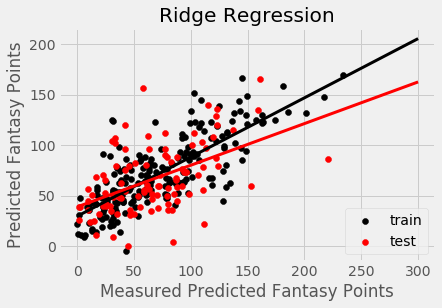

Performance Evaluation, alpha = 100
--------------------------------

Sum of Coefficients: 
 42.3936963276
Train Mean squared error: 969.11
Test Mean squared error: 1256.15
Training R^2 score: 0.56
Testing R^2 score: 0.24


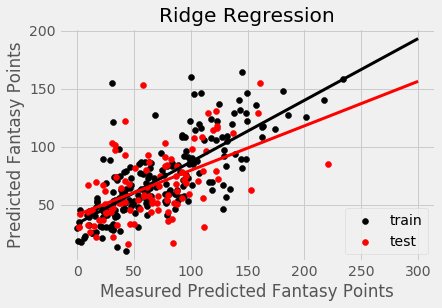

Performance Evaluation, alpha = 1000
--------------------------------

Sum of Coefficients: 
 34.750412979
Train Mean squared error: 1099.30
Test Mean squared error: 1169.59
Training R^2 score: 0.50
Testing R^2 score: 0.29


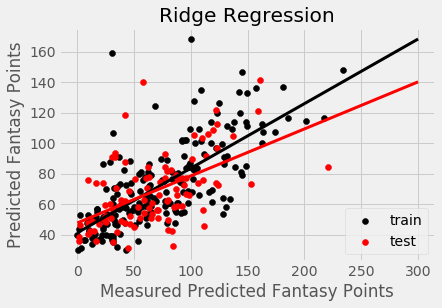

Performance Evaluation, alpha = 10000
--------------------------------

Sum of Coefficients: 
 15.0113235471
Train Mean squared error: 1584.01
Test Mean squared error: 1331.64
Training R^2 score: 0.28
Testing R^2 score: 0.19


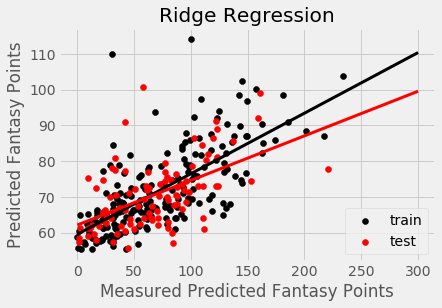

Performance Evaluation, alpha = 100000
--------------------------------

Sum of Coefficients: 
 2.21797649367
Train Mean squared error: 2096.55
Test Mean squared error: 1605.59
Training R^2 score: 0.05
Testing R^2 score: 0.02


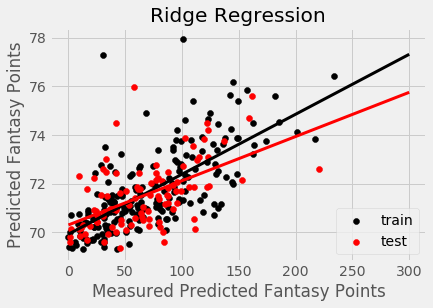

In [661]:
from sklearn.linear_model import Ridge
# capture train and test mean squared error
train_error, test_error = [], []
alphas = [0.01, 0.1, 1.0, 10, 100, 1000, 10000, 100000]
for a in alphas:
    # Create linear regression object
    ridge = Ridge(alpha=a)

    # Train the model using the training sets
    ridge.fit(X_train, y_train)

    # Predict fantasy points on train and test data
    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)
    
    print('Performance Evaluation, alpha = {}'.format(a))
    print('--------------------------------')
    print('')
    
    # The coefficients
    print('Sum of Coefficients: \n', np.sum(ridge.coef_))
    
    # capture mean squared errors for graphing
    train_error.append(mean_squared_error(y_train_pred, y_train))
    test_error.append(mean_squared_error(y_test_pred, y_test))
    
    # The mean squared error
    print("Train Mean squared error: %.2f"
          % mean_squared_error(y_train_pred, y_train))
    print("Test Mean squared error: %.2f"
          % mean_squared_error(y_test_pred, y_test))

    # Train R2
    print('Training R^2 score: %.2f' % ridge.score(X_train, y_train))
    # Test R2
    print('Testing R^2 score: %.2f' % ridge.score(X_test, y_test))

    # Plot outputs
    plt.scatter(y_train,  y_train_pred, color='black', label='train')
    plt.scatter(y_test,  y_test_pred, color='red', label='test')
    plt.title('Ridge Regression')
    plt.xlabel('Measured Predicted Fantasy Points')
    plt.ylabel('Predicted Fantasy Points')

    # plot best fit lines for train and test
    fit = np.polyfit(y_train, y_train_pred, deg=1)
    poly = np.poly1d(fit)
    xpoints = np.linspace(0.0, 300, 100)
    plt.plot(xpoints, poly(xpoints), color='black', linewidth=3)

    fit = np.polyfit(y_test, y_test_pred, deg=1)
    poly = np.poly1d(fit)
    xpoints = np.linspace(0.0, 300, 100)
    plt.plot(xpoints, poly(xpoints), color='red', linewidth=3)
    plt.legend(loc='lower right')
    plt.show()

#### Choosing the best alpha value

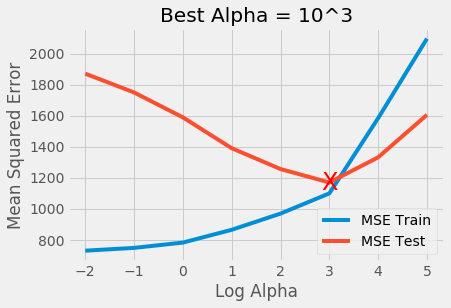

In [662]:
plt.plot(np.log10(alphas), train_error, label='MSE Train')
plt.plot(np.log10(alphas), test_error, label='MSE Test')
plt.legend()
plt.xlabel('Log Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Best Alpha = 10^3')
plt.text(3,1125, 'X', horizontalalignment='center', color='red', fontsize=24)

### RidgeCV: Regression Model with Cross-Validation and Regularization
http://scikit-learn.org/stable/modules/cross_validation.html
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html

Performance Evaluation, alpha = 1267.8391959798996
--------------------------------

Sum of Coefficients: 
 33.4950165763
Train Mean squared error: 1121.89
Test Mean squared error: 1166.69
Training R^2 score: 0.49
Testing R^2 score: 0.29


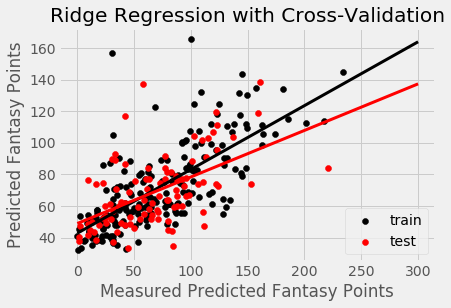

In [722]:
alphas = np.linspace(100, 1500, 200)
parameters = {'alpha': alphas}

# Create linear regression object
ridgecv = GridSearchCV(Ridge(), parameters, cv=50)

# Train the model using the training sets
ridgecv.fit(X_train, y_train)

# Predict fantasy points on train and test data
y_train_pred = ridgecv.predict(X_train)
y_test_pred = ridgecv.predict(X_test)

print('Performance Evaluation, alpha = {}'.format(ridgecv.best_estimator_.alpha))
print('--------------------------------')
print('')

# The coefficients
print('Sum of Coefficients: \n', np.sum(ridgecv.best_estimator_.coef_))

# capture mean squared errors for graphing
train_error.append(mean_squared_error(y_train_pred, y_train))
test_error.append(mean_squared_error(y_test_pred, y_test))

# The mean squared error
print("Train Mean squared error: %.2f"
      % mean_squared_error(y_train_pred, y_train))
print("Test Mean squared error: %.2f"
      % mean_squared_error(y_test_pred, y_test))

# Train R2
print('Training R^2 score: %.2f' % ridgecv.score(X_train, y_train))
# Test R2
print('Testing R^2 score: %.2f' % ridgecv.score(X_test, y_test))

# Plot outputs
plt.scatter(y_train,  y_train_pred, color='black', label='train')
plt.scatter(y_test,  y_test_pred, color='red', label='test')
plt.title('Ridge Regression with Cross-Validation')
plt.xlabel('Measured Predicted Fantasy Points')
plt.ylabel('Predicted Fantasy Points')

# plot best fit lines for train and test
fit = np.polyfit(y_train, y_train_pred, deg=1)
poly = np.poly1d(fit)
xpoints = np.linspace(0.0, 300, 100)
plt.plot(xpoints, poly(xpoints), color='black', linewidth=3)

fit = np.polyfit(y_test, y_test_pred, deg=1)
poly = np.poly1d(fit)
xpoints = np.linspace(0.0, 300, 100)
plt.plot(xpoints, poly(xpoints), color='red', linewidth=3)
plt.legend(loc='lower right')
plt.show()

### Final Attempt:  Add Some Flexibility with Polynomial Features + RidgeCV
http://www.cs.haifa.ac.il/~rita/uml_course/add_mat/PCA.pdf

In [674]:
poly_features = PolynomialFeatures(2)
Xp = poly_features.fit_transform(X)
print(Xp.shape)
pca = PCA(n_components=100)
Xpca = pca.fit_transform(Xp)
print(np.sum(pca.explained_variance_ratio_))

Xp_train, Xp_test, y_train, y_test = train_test_split(Xpca, 
                                                      y, 
                                                      test_size=0.33, 
                                                      random_state=1234)

print(Xpca.shape)

(306, 2145)
0.965595125932
(306, 100)


Performance Evaluation, alpha = 838.6934673366834
--------------------------------

Sum of Coefficients: 
 -14.4101452102
Train Mean squared error: 629.99
Test Mean squared error: 1426.08
Training R^2 score: 0.71
Testing R^2 score: 0.13


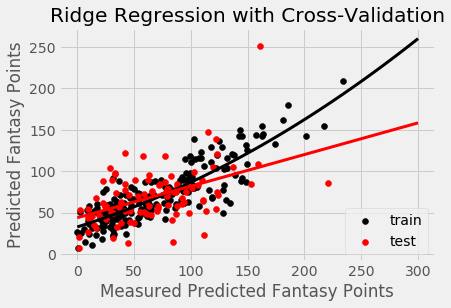

In [723]:
# capture train and test mean squared error
alphas = alphas = np.linspace(100, 1500, 200)

# Create linear regression object
ridgecv = RidgeCV(alphas=alphas, cv=5)

# Train the model using the training sets
ridgecv.fit(Xp_train, y_train)

# Predict fantasy points on train and test data
y_train_pred = ridgecv.predict(Xp_train)
y_test_pred = ridgecv.predict(Xp_test)

print('Performance Evaluation, alpha = {}'.format(ridgecv.alpha_))
print('--------------------------------')
print('')

# The coefficients
print('Sum of Coefficients: \n', np.sum(ridgecv.coef_))

# capture mean squared errors for graphing
train_error.append(mean_squared_error(y_train_pred, y_train))
test_error.append(mean_squared_error(y_test_pred, y_test))

# The mean squared error
print("Train Mean squared error: %.2f"
      % mean_squared_error(y_train_pred, y_train))
print("Test Mean squared error: %.2f"
      % mean_squared_error(y_test_pred, y_test))

# Train R2
print('Training R^2 score: %.2f' % ridgecv.score(Xp_train, y_train))
# Test R2
print('Testing R^2 score: %.2f' % ridgecv.score(Xp_test, y_test))

# Plot outputs
plt.scatter(y_train,  y_train_pred, color='black', label='train')
plt.scatter(y_test,  y_test_pred, color='red', label='test')
plt.title('Ridge Regression with Cross-Validation')
plt.xlabel('Measured Predicted Fantasy Points')
plt.ylabel('Predicted Fantasy Points')

# plot best fit lines for train and test
fit = np.polyfit(y_train, y_train_pred, deg=2)
poly = np.poly1d(fit)
xpoints = np.linspace(0.0, 300, 100)
plt.plot(xpoints, poly(xpoints), color='black', linewidth=3)

fit = np.polyfit(y_test, y_test_pred, deg=2)
poly = np.poly1d(fit)
xpoints = np.linspace(0.0, 300, 100)
plt.plot(xpoints, poly(xpoints), color='red', linewidth=3)
plt.legend(loc='lower right')
plt.show()

In [725]:
d = {'x_models': ['Linear', 'Ridge', 'RidgeCV', 'Poly-PCA-RidgeCV'],
     'MSE_train': [726.89, 1099.30, 1121.89, 629.99],
     'MSE_test': [1958.35, 1169.59, 1166.69, 1426.00],
     'r2_train': [0.67, 0.50, 0.49, 0.71],
     'r2_test': [-0.19, 0.29, 0.29, 0.13]}

results = pd.DataFrame(d)

In [726]:
results

MSE_test  MSE_train  r2_test  r2_train          x_models
0   1958.35     726.89    -0.19      0.67            Linear
1   1169.59    1099.30     0.29      0.50             Ridge
2   1166.69    1121.89     0.29      0.49           RidgeCV
3   1426.00     629.99     0.13      0.71  Poly-PCA-RidgeCV

### Step 6: Lessons Learned and Next Steps

#### Conclusions
- Model performance improves with regularization and cross-validation
    - "if you are building linear models without any regularization, you must be really special" - See more at: http://blog.nycdatascience.com/meetup/featured-talk-1-kaggle-data-scientist-owen-zhang/#sthash.ttIVvIie.dpuf - Top Kaggle Data Scientist Owen Zhang 
- Added flexibility did not improve performance
- Need more data!
- Need more and better features
- Feature selection
- Advanced algorithms, RandomForest, XGBoost, Bayesian Regression, KNN, RNN, etc.

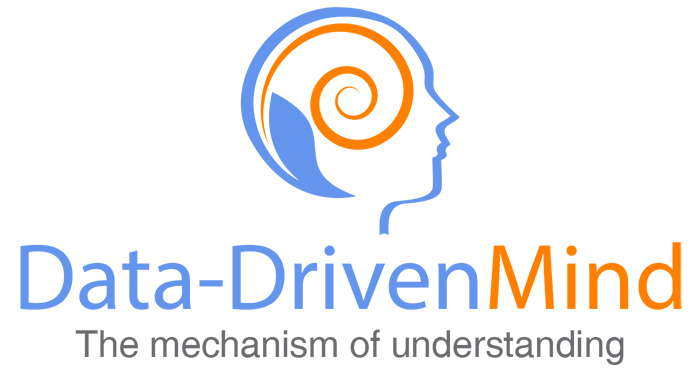

In [729]:
from IPython.display import Image
Image(filename = 'Logo Image - 9.2016 copy.jpg')

### Upcoming Boot-Camps Hosted by Data-Driven Mind
- October 2017: Learn Data Science by Collaborating and Competing

